In [141]:
import pandas as pd
import numpy as np
import gensim
import nltk
import datetime
import time
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel,Phrases
from gensim.models.phrases import Phraser
from gensim.models import word2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [130]:
movies1_df = pd.read_json('data/eng_1_430.json')
movies2_df = pd.read_json('data/eng_431_601.json')
movies = movies1_df.append(movies2_df)
print(movies.shape)
movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
10,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
100,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
1000,r is a 1995 American romantic drama television...,The Affair (1995 film)


In [135]:
movies.shape

(56005, 2)

In [142]:
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series', 'story', 'american', 'starring', ]

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = Phrases(words, min_count = bi_min)
    bigram_mod = Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    words = list(df['summary'])
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[plot] for plot in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=15, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [143]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(movies)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed) 

Time:  0:01:56.023613


In [35]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [137]:
doc_sample = movies[movies['title'] == "Breakfast at Tiffany's (film)"].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['', 'Early', 'one', 'morning', 'a', 'taxi', 'pulls', 'up', 'in', 'front', 'of', 'Tiffany', '', 'Co', '', 'and', 'from', 'it', 'emerges', 'elegantly', 'dressed', 'Holly', 'Golightly', 'carrying', 'a', 'paper', 'bag', 'containing', 'her', 'breakfast', 'After', 'looking', 'into', 'its', 'windows', 'she', 'strolls', 'to', 'her', 'apartment', 'and', 'has', 'to', 'fend', 'off', 'her', 'date', 'from', 'the', 'night', 'before', 'Once', 'inside', 'Holly', 'cannot', 'find', 'her', 'keys', 'so', 'she', 'buzzes', 'her', 'landlord', 'Mr', 'Yunioshi', 'to', 'let', 'her', 'in', 'Later', 'she', 'is', 'awakened', 'by', 'new', 'neighbor', 'Paul', 'Varjak', 'who', 'rings', 'her', 'doorbell', 'to', 'get', 'into', 'the', 'building', 'The', 'pair', 'chat', 'as', 'she', 'dresses', 'to', 'leave', 'for', 'her', 'weekly', 'visit', 'to', 'Sally', 'Tomato', 'a', 'mobster', 'incarcerated', 'at', 'Sing', 'Sing', 'Tomatos', 'lawyer', 'pays', 'her', '100', 'a', 'week', 'to', 'deliver', 'the', 'we

In [39]:
processed_docs = movies['summary'].map(preprocess)


In [40]:
dictionary  = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    count += 1
    if count > 10:
        break

In [41]:
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

In [42]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [43]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


In [144]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=8,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Topic : 0 Word: 0.008*"police" + 0.006*"killed" + 0.006*"car" + 0.005*"man" + 0.005*"kill" + 0.005*"tells" + 0.005*"john" + 0.005*"finds" + 0.004*"one" + 0.004*"gang"
Topic : 1 Word: 0.007*"documentary" + 0.006*"films" + 0.005*"written" + 0.005*"first" + 0.005*"produced" + 0.005*"stars" + 0.005*"also" + 0.004*"released" + 0.004*"john" + 0.004*"movie"
Topic : 2 Word: 0.005*"joe" + 0.005*"school" + 0.005*"new" + 0.004*"money" + 0.004*"charlie" + 0.004*"get" + 0.003*"bill" + 0.003*"one" + 0.003*"johnny" + 0.003*"steve"
Topic : 3 Word: 0.037*"sam" + 0.035*"david" + 0.027*"michael" + 0.019*"sarah" + 0.017*"henry" + 0.015*"matt" + 0.014*"martin" + 0.013*"bugs" + 0.012*"dan" + 0.011*"claire"
Topic : 4 Word: 0.008*"father" + 0.007*"tells" + 0.007*"family" + 0.006*"mother" + 0.006*"life" + 0.005*"home" + 0.005*"wife" + 0.005*"love" + 0.004*"husband" + 0.004*"finds"
Topic : 5 Word: 0.007*"back" + 0.006*"house" + 0.005*"one" + 0.005*"find" + 0.004*"tells" + 0.004*"finds" + 0.003*"two" + 0.003*"se

In [146]:
coherence_values = []
model_list = []
for num_topics in range(2,50,6):
    model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=num_topics,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, 
                                    texts=bigram,
                                    dictionary=m_id2word,
                                   coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

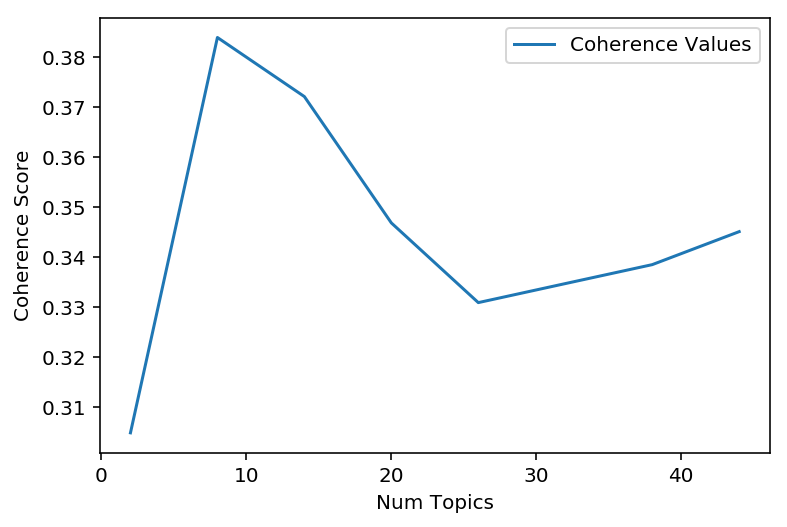

In [147]:

X = np.arange(2,50,6)

fig, ax = plt.subplots()
ax.plot(X, coherence_values, label="Coherence Values")
ax.set_xlabel('Num Topics')
ax.set_ylabel('Coherence Score')
plt.legend()
plt.show()

In [106]:
for m, cv in zip(X, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4265
Num Topics = 8  has Coherence Value of 0.4833
Num Topics = 14  has Coherence Value of 0.421
Num Topics = 20  has Coherence Value of 0.4513
Num Topics = 26  has Coherence Value of 0.4389
Num Topics = 32  has Coherence Value of 0.4396
Num Topics = 38  has Coherence Value of 0.443


In [69]:
train_vecs = []
for i in range(len(movies)):
    top_topics = lda_model.get_document_topics(corpus_tfidf[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(8)]
    train_vecs.append(topic_vec)

In [123]:
train_vecs[0]

[0.012516569,
 0.12139622,
 0.54146653,
 0.012518243,
 0.0125198215,
 0.088762626,
 0.012531708,
 0.1982883]

In [120]:
topic = train_vecs[0].index(max(train_vecs[0]))

### Extracting Target

In [121]:
topic_names = ['Topic1','Topic2','Topic3','Topic4','Topic5','Topic6','Topic7','Topic8']
topic_names[topic]

'Topic3'

In [125]:
topic_nums = [vec.index(max(vec)) for vec in train_vecs]
topics = np.array([topic_names[topic] for topic in topic_nums])
topics[:10]

array(['Topic3', 'Topic3', 'Topic3', 'Topic3', 'Topic3', 'Topic7',
       'Topic7', 'Topic7', 'Topic3', 'Topic8'], dtype='<U6')

In [126]:
movies['label'] = topics
movies.head()

,summary,title,label
0,In 1699 Dr Lemuel Gulliver Kerwin Mathews is ...,The 3 Worlds of Gulliver,Topic3
1,The Man Edmond OBrien is the accomplice of Ma...,The 3rd Voice,Topic3
10,AbdullaMahipal is a smart and brave young man...,Abdulla (1960 film),Topic3
100,is a French film directed by Julien Duvivier ...,Boulevard (1960 film),Topic3
1000,A Greek military hero named Darios Rory Calho...,The Colossus of Rhodes (film),Topic3


### Word Embedding

In [114]:
text = movies['summary']
total_vocabulary = set(word for summary in text for word in summary)

In [115]:
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [116]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [117]:
rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [127]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]
scores = [(name, cross_val_score(model, text, topic_nums, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default va

In [128]:
scores

[('Random Forest', 0.7227161659272903),
 ('Support Vector Machine', 0.6471982785354672),
 ('Logistic Regression', 0.6902572904075763)]